**Research Topics in Computer Vision :: Evaluating the Mask RCNN** 


In [1]:
from google.colab import drive                # Mounting Google Drive that contains the datasets and annotations
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch, torchvision                     # Installing Detectron 2 and its dependencies
assert torch.__version__.startswith("1.8")   
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 770kB/s 
     |████████████████████████████████| 51kB 3.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=073292c8d0b8a96ce4c516a2ecc6abebf8e778794a0c5bd9b072a2cf239a4268
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore
ERROR: fvcore 0.1.3.post20210317 has requirement pyyaml>=5.1, but you'll have pyyaml 3.13 which is incompatible.
ERROR: omegaconf 2.0.6 has requirement PyYAML>=5.1.*, but you'll have pyyaml 3.13 which is incompatible.


In [3]:
!pip install pyyaml==5.1                  
!gcc --version

     |████████████████████████████████| 276kB 4.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=e9404efbfde4b24099ad900b424cdef507a5201e66705b3d9c99e9cab4382d31
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
import numpy as np                                 # Importing necessary python libraries
import os, json, cv2, random
from google.colab.patches import cv2_imshow

In [5]:
import detectron2                                  # Importing Detectron2 libraries
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


In [6]:
cfg = get_cfg()                                         # Getting Mask RCNN modeland weights with the Resnet 101 backend
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5             # Setting threshold for this model to 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_a3ec72.pkl: 254MB [00:15, 16.2MB/s]                           


***Registering the Coco Instances Validation 2017 Dataset***


In [ ]:
register_coco_instances("coco_val", {}, "/content/drive/MyDrive/instances_val2017.json", "/content/drive/MyDrive/val2017")
dataset_dicts = DatasetCatalog.get("coco_val")         
cocoval_metadata = MetadataCatalog.get("coco_val")

[05/23 12:02:16 d2.data.datasets.coco]: Loading /content/drive/MyDrive/instances_val2017.json takes 1.70 seconds.
[05/23 12:02:16 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /content/drive/MyDrive/instances_val2017.json


***Registering the Tiny Voc Coco Train Dataset***

In [7]:
register_coco_instances("tiny_voc_train", {}, "/content/drive/MyDrive/tiny_voc_coco_train.json", "/content/drive/MyDrive/voc_train_images")
dataset_dicts = DatasetCatalog.get("tiny_voc_train")         
cocoval_metadata = MetadataCatalog.get("tiny_voc_train")

WARNING [05/23 13:01:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/23 13:01:02 d2.data.datasets.coco]: Loaded 1349 images in COCO format from /content/drive/MyDrive/tiny_voc_coco_train.json


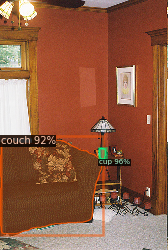

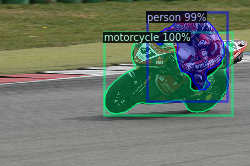

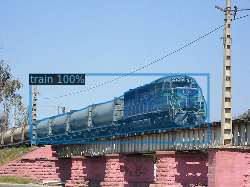

In [9]:
for d in random.sample(dataset_dicts, 3):               # Getting 3 samples from the dataset and perform inference to verify setting up
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cocoval_metadata,
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

***Evaluating the Coco Validation 2017 Dataset with respect to bounding boxes and segmentation masks***

In [ ]:
evaluator = COCOEvaluator("coco_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "coco_val")             # Perform Evaluation on Dataset given
print(inference_on_dataset(predictor.model, val_loader, evaluator))

***Evaluating the Tiny Voc Train Dataset with respect to bounding boxes and segmentation masks***

In [10]:
evaluator = COCOEvaluator("tiny_voc_train", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "tiny_voc_train")             # Perform Evaluation on Dataset given
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [05/23 13:02:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/23 13:02:13 d2.data.datasets.coco]: Loaded 1349 images in COCO format from /content/drive/MyDrive/tiny_voc_coco_train.json
[05/23 13:02:13 d2.data.build]: Distribution of instances among all 80 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|    person     | 797          |   bicycle    | 99           |      car      | 238          |
|  motorcycle   | 91           |   airplane   | 103          |      bus      | 111          |
|     train     | 87           |    truck     | 0            |     boat      | 99           |
| traffic light | 0            | fire hydrant | 0            |   stop sign   | 0            |
| parking meter | 0            |    bench     | 0            |     bird      | 130      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[05/23 13:02:16 d2.evaluation.evaluator]: Inference done 11/1349. 0.1846 s / img. ETA=0:04:13
[05/23 13:02:21 d2.evaluation.evaluator]: Inference done 37/1349. 0.1852 s / img. ETA=0:04:11
[05/23 13:02:26 d2.evaluation.evaluator]: Inference done 63/1349. 0.1854 s / img. ETA=0:04:07
[05/23 13:02:31 d2.evaluation.evaluator]: Inference done 90/1349. 0.1851 s / img. ETA=0:04:01
[05/23 13:02:36 d2.evaluation.evaluator]: Inference done 116/1349. 0.1861 s / img. ETA=0:03:56
[05/23 13:02:41 d2.evaluation.evaluator]: Inference done 143/1349. 0.1858 s / img. ETA=0:03:51
[05/23 13:02:46 d2.evaluation.evaluator]: Inference done 169/1349. 0.1863 s / img. ETA=0:03:46
[05/23 13:02:51 d2.evaluation.evaluator]: Inference done 195/1349. 0.1865 s / img. ETA=0:03:42
[05/23 13:02:56 d2.evaluation.evaluator]: Inference done 221/1349. 0.1868 s / img. ETA=0:03:37
[05/23 13:03:01 d2.evaluation.evaluator]: Inference done 247/1349. 0.1869 s / img. ETA=0:03:32
[05/23 13:03:06 d2.evaluation.evaluator]: Inference do